# **Neural Style Transfer Project**

Submitted by: Anna Aba

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

At tensorflow version 2.3.0 : eager execution is enabled by default, so we disable 
it .




In [2]:
if tf.executing_eagerly():
  tf.compat.v1.disable_eager_execution()

Download the VGG16 model.

In [3]:
from keras.applications import VGG16, vgg16
from keras import backend as K

model = VGG16()
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Loading the original content image and the style image.

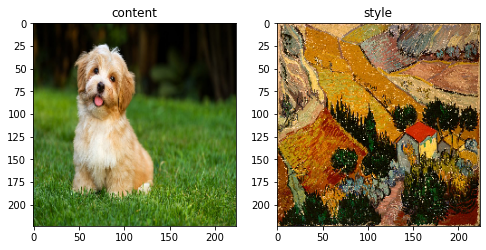

In [23]:
from keras.preprocessing.image import load_img, img_to_array

content_img = load_img('dog.jpg', target_size=(224, 224))
style_img = load_img('house_image.jpg', target_size=(224, 224))

content = img_to_array(content_img)  # to NumPy (224,224,3)
content = content[None] # (224,224,3)->(1,224,224,3)
content = vgg16.preprocess_input(content)

style = img_to_array(style_img)  # to NumPy (224,224,3)
style = style[None] # (224,224,3)->(1,224,224,3)
style = vgg16.preprocess_input(style)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title('content')
plt.imshow(content_img)
plt.subplot(1,2,2)
plt.title('style')
plt.imshow(style_img)
plt.show()

### The content loss function.

Compute the euclidean distance between the feature representations of  the generated image and the content image.




In [6]:
def content_loss(content_image, num_layer):

  L = model.layers[num_layer].output[0,:,:,:]
  layer_l = K.function(inputs=[model.input], outputs=[L])
  F_c = L
  P_c = layer_l(content_image)[0]
  loss = K.sum(K.square(F_c - P_c)) / 2

  return loss

### The style loss function

Define the style layers.

In [7]:
def style_layers():
  
   layers = [1, 4, 7, 11, 15]
   
   return layers

Function that computes all gram matrices that needed for the **original** style image.

In [8]:
def gram_matrices_of_style_image(style_image):

  num_layers = style_layers()
  matrices = []

  for i in num_layers:
    L = model.layers[i].output[0,:,:,:]
    layer_l = K.function(inputs=[model.input], outputs=[L])
    P = layer_l(style_image)[0]
    P = K.batch_flatten(K.permute_dimensions(P, (2, 0, 1)))
    matrix = tf.matmul(P, tf.transpose(P)) 
    matrices.append(matrix)

  return matrices

Function that computes the gram matrix of the generated image at given layer.

Returns the euclidean distance between the gram matricies of style image and generated image.

In [9]:
def style_loss_of_layer(style_image_gram, num_layer):

  L = model.layers[num_layer].output[0,:,:,:]
  F = L

  F = K.batch_flatten(K.permute_dimensions(F, (2, 0, 1)))
  gram_matrix = tf.matmul(F, tf.transpose(F))

  G = gram_matrix
  A = style_image_gram

  shape = L.shape
  new_shape = (shape[-1],shape[0]*shape[1])

  N = new_shape[0]  # number of filters in layer L
  M = new_shape[1]  # number of elementes in each filter

  loss = K.sum(K.square(G - A)) / (4 * (N ** 2) * (M ** 2))
  
  return loss

Function that computes the final style loss.

In [10]:
def style_loss(style_gram_matrices):

  num_layers = style_layers()
  w = 1 / len(num_layers)
  loss = 0

  for i,l in enumerate(num_layers):
    loss += w * style_loss_of_layer(style_gram_matrices[i], l)

  return loss

Define all three images.

In [36]:
# content image :
content_image = content

# style image :
style_image = style

# generated image - random noise image :
X = np.random.random((224,224,3))*10+128
X = X[None].astype(np.float32) 
X = vgg16.preprocess_input(X)

Define the loss and the gradients.

In [37]:
# content loss: 
layer_c =  11  # num of layer for content 
alpha = 1
loss_c = content_loss(content_image, layer_c)

# style loss:
beta =  alpha / 1e-3
style_gram_matrices = gram_matrices_of_style_image(style_image)
loss_s = style_loss(style_gram_matrices)

# Total loss:
J = alpha * loss_c + beta * loss_s

grads = K.gradients(J,[model.input])[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
calc_gradient = K.function(inputs=[model.input], outputs=[J, grads])

The function we want to minimise. We use it for the **fmin_l_bfgs_b** function.

In [38]:
def get_loss_and_grads(X):

  loss, grads = calc_gradient(X.reshape(shape))

  return loss.astype(np.float64), grads.flatten().astype(np.float64)

Run the **fmin_l_bfgs_b** algorithm which minimises our loss and passes back this value and the gradients.

In [39]:
from scipy.optimize import fmin_l_bfgs_b

shape = X.shape
X = X.flatten()
losses = []
for i in range(500):
    X, loss, info = fmin_l_bfgs_b(func=get_loss_and_grads, x0=X, maxfun=20)
    losses.append(loss)

X = X.reshape(shape)

### Final result

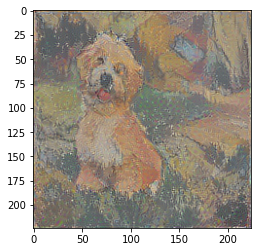

In [40]:
X_final = deprocess_image(X[0].copy())
X_final = cv2.cvtColor(X_final,cv2.COLOR_BGR2RGB)
plt.imshow(X_final)
plt.show()

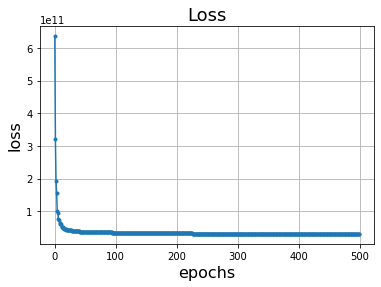

In [41]:
plt.plot(losses,'.-')
plt.title("Loss",fontsize=18)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.grid()
plt.show()

### Final presentation:

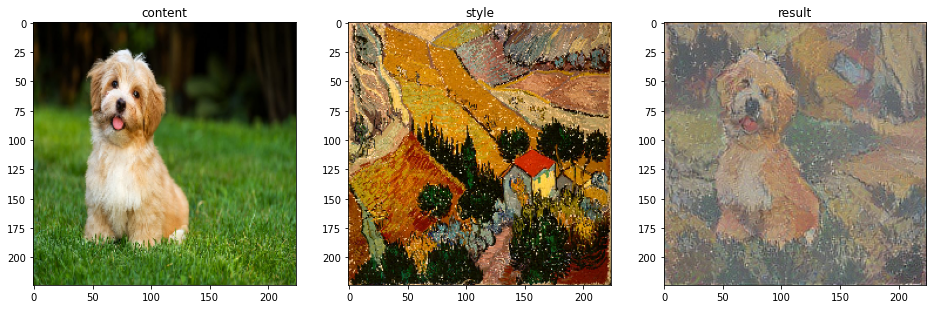

In [43]:
plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
plt.title('content')
plt.imshow(content_img)

plt.subplot(1,3,2)
plt.title('style')
plt.imshow(style_img)

plt.subplot(1,3,3)
plt.title('result')
plt.imshow(img)
plt.show()

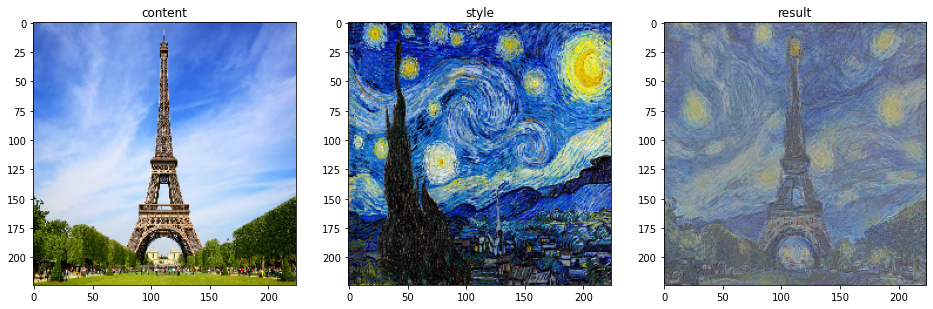

In [21]:
# First example:

plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
plt.title('content')
plt.imshow(content_img)

plt.subplot(1,3,2)
plt.title('style')
plt.imshow(style_img)

plt.subplot(1,3,3)
plt.title('result')
plt.imshow(img)
plt.show()